In [1]:
!nvidia-smi

Wed Apr 15 15:40:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
###download stanford_dog_breed_dataset

!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

--2020-04-15 15:40:15--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  59.9MB/s    in 11s     

2020-04-15 15:40:26 (71.1 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-04-15 15:40:29--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  29.9MB/s    in 0.7s    

2020-04-15 15:40:30 (29.9 MB/s) - ‘annotat

In [0]:
###untar downloaded data

!tar -xf /content/images.tar
!tar -xf /content/lists.tar
!tar -xf /content/annotation.tar

In [0]:
!rm *.tar

In [0]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    },
    'faster_rcnn_inception_resnet_v2': {
         'model_name': 'faster_rcnn_inception_resnet_v2_atrous_oid_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_resnet_v2_atrous_oid.config',
    }

}

# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_resnet_v2'

In [0]:
###installing required packages

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -qq Cython contextlib2 pillow lxml matplotlib

!pip install -qq pycocotools
!pip install numpy==1.17.4

In [7]:
%tensorflow_version 1.x
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
from glob import glob
import os
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict
from matplotlib import pyplot as plt
import shutil
import urllib.request
import tarfile

from google.colab import files

TensorFlow 1.x selected.


In [4]:
tf.__version__

'1.15.2'

In [0]:
!mkdir dog_breed

In [9]:
cd dog_breed

/content/dog_breed


In [0]:
# creating a directory to store the training and testing data
!mkdir data

# folders for the training and testing data.
!mkdir data/images data/train_labels data/test_labels


# combining the images and annotation in the training folder:
# moves the images to data folder
!mv /content/Images/*/* data/images

# moves the annotations to data folder
!mv /content/Annotation/*/* data/train_labels

In [0]:
!ls data/train_labels/* | sort -R | head -800 | xargs -I{} mv {} data/test_labels

In [12]:
ls -1 data/train_labels/ | wc -l

19780


In [13]:
ls -1 data/test_labels/ | wc -l

800


In [14]:
%cd /content/dog_breed/data


images_extension = 'jpg'

###convert xml file to csv
def xml_to_csv(path):
  #print(path)
  classes_names = []
  xml_list = []

  for xml_file in glob(path + '/*'):
    #print (xml_file)
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      if (root.find('filename').text == '%s'):
        img_fm=xml_file.split('/')[-1]
        #print(img_fm)
      else:
        img_fm=root.find('filename').text
        #print(img_fm)
      value = (img_fm + '.' + images_extension,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

# for both the train_labels and test_labels csv files, it runs the xml_to_csv() above.
for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

# Creating the `label_map.pbtxt` file
label_map_path = os.path.join("label_map.pbtxt")

pbtxt_content = ""

#creats a pbtxt file the has the class names.
for i, class_name in enumerate(classes):
    # display_name is optional.
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: '{2}'\n }}\n\n".format(i + 1, class_name, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

/content/dog_breed/data
Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [15]:
train=pd.read_csv('/content/dog_breed/data/train_labels.csv')
train.head(50)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,n02097209_3430.jpg,255,310,standard_schnauzer,52,27,217,267
1,n02094258_322.jpg,182,227,Norwich_terrier,0,4,167,226
2,n02085782_626.jpg,150,150,Japanese_spaniel,1,0,149,149
3,n02099267_957.jpg,480,500,flat-coated_retriever,77,3,349,498
4,n02096051_1111.jpg,363,500,Airedale,142,186,302,441
5,n02100877_2389.jpg,186,207,Irish_setter,29,20,164,206
6,n02100735_6303.jpg,500,369,English_setter,35,23,417,347
7,n02112018_336.jpg,500,375,Pomeranian,187,204,264,294
8,n02112018_336.jpg,500,375,Pomeranian,382,204,499,280
9,n02107683_1421.jpg,500,334,Bernese_mountain_dog,74,64,376,331


In [16]:
!cat label_map.pbtxt

item {
    id: 1
    name: 'Afghan_hound'
    display_name: 'Afghan_hound'
 }

item {
    id: 2
    name: 'African_hunting_dog'
    display_name: 'African_hunting_dog'
 }

item {
    id: 3
    name: 'Airedale'
    display_name: 'Airedale'
 }

item {
    id: 4
    name: 'American_Staffordshire_terrier'
    display_name: 'American_Staffordshire_terrier'
 }

item {
    id: 5
    name: 'Appenzeller'
    display_name: 'Appenzeller'
 }

item {
    id: 6
    name: 'Australian_terrier'
    display_name: 'Australian_terrier'
 }

item {
    id: 7
    name: 'Bedlington_terrier'
    display_name: 'Bedlington_terrier'
 }

item {
    id: 8
    name: 'Bernese_mountain_dog'
    display_name: 'Bernese_mountain_dog'
 }

item {
    id: 9
    name: 'Blenheim_spaniel'
    display_name: 'Blenheim_spaniel'
 }

item {
    id: 10
    name: 'Border_collie'
    display_name: 'Border_collie'
 }

item {
    id: 11
    name: 'Border_terrier'
    display_name: 'Border_terrier'
 }

item {
    id: 12
    name: 'Boston

In [17]:
%cd /content/dog_breed/data
# path to images
images_path = 'images'

###check images w.r.t annotation
for CSV_FILE in ['train_labels.csv', 'test_labels.csv']:
  with open(CSV_FILE, 'r') as fid:  
      print('[*] Checking file:', CSV_FILE) 
      file = csv.reader(fid, delimiter=',')
      first = True 
      cnt = 0
      error_cnt = 0
      error = False
      for row in file:
          if error == True:
              error_cnt += 1
              error = False         
          if first == True:
              first = False
              continue     
          cnt += 1      
          name, width, height, xmin, ymin, xmax, ymax = row[0], int(row[1]), int(row[2]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
          path = os.path.join(images_path, name)
          #print(path)
          img = cv2.imread(path)         
          if type(img) == type(None):
              error = True
              print('Could not read image', img)
              continue     
          org_height, org_width = img.shape[:2]     
          if org_width != width:
              error = True
              print('Width mismatch for image: ', name, width, '!=', org_width)     
          if org_height != height:
              error = True
              print('Height mismatch for image: ', name, height, '!=', org_height) 
          if xmin > org_width:
              error = True
              print('XMIN > org_width for file', name)  
          if xmax > org_width:
              error = True
              print('XMAX > org_width for file', name)
          if ymin > org_height:
              error = True
              print('YMIN > org_height for file', name)
          if ymax > org_height:
              error = True
              print('YMAX > org_height for file', name)
          if error == True:
              print('Error for file: %s' % name)
              print()
      print()
      print('Checked %d files and realized %d errors' % (cnt, error_cnt))
      print("-----")

/content/dog_breed/data
[*] Checking file: train_labels.csv
XMAX > org_width for file n02106030_3948.jpg
YMAX > org_height for file n02106030_3948.jpg
Error for file: n02106030_3948.jpg

XMAX > org_width for file n02098105_2063.jpg
Error for file: n02098105_2063.jpg


Checked 21263 files and realized 2 errors
-----
[*] Checking file: test_labels.csv

Checked 863 files and realized 0 errors
-----


In [0]:
!rm images/n02106030_3948.jpg
!rm images/n02098105_2063.jpg

In [0]:

df = pd.read_csv('/content/dog_breed/data/train_labels.csv')
df = df[df['filename'] != 'n02106030_3948.jpg']
df = df[df['filename'] != 'n02098105_2063.jpg']

#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/dog_breed/data/train_labels.csv')


df = pd.read_csv('/content/dog_breed/data/test_labels.csv')

df = df[df['filename'] != 'n02106030_3948.jpg']
df = df[df['filename'] != 'n02098105_2063.jpg']
#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/dog_breed/data/test_labels.csv')


In [20]:
%cd /content/dog_breed/
!git clone --q https://github.com/tensorflow/models.git

/content/dog_breed


In [21]:
%cd /content/dog_breed/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/dog_breed/models/research/:/content/dog_breed/models/research/slim/'

/content/dog_breed/models/research


In [22]:
# testing the model builder
!python3 object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

In [23]:

from object_detection.utils import dataset_util
%cd /content/dog_breed/models/

DATA_BASE_PATH = '/content/dog_breed/data/'
image_dir = DATA_BASE_PATH +'images/'
dog_classes=train['class'].unique()
    

def class_text_to_int(row_label):

	'''
	if row_label == "Chihuahua":
		return 1
	elif row_label == "Japanese_spaniel":
		return 2
	elif row_label == "Maltese_dog":
		return 3
	elif row_label == "Pekinese":
		return 4
	elif row_label == "Shih-Tzu":
		return 5
	'''
	if row_label == "Afghan_hound":
		return 1
	elif row_label == "African_hunting_dog":
		return 2
	elif row_label == "Airedale":
		return 3
	elif row_label == "American_Staffordshire_terrier":
		return 4
	elif row_label == "Appenzeller":
		return 5
	elif row_label == "Australian_terrier":
		return 6
	elif row_label == "Bedlington_terrier":
		return 7
	elif row_label == "Bernese_mountain_dog":
		return 8
	elif row_label == "Blenheim_spaniel":
		return 9
	elif row_label == "Border_collie":
		return 10
	elif row_label == "Border_terrier":
		return 11
	elif row_label == "Boston_bull":
		return 12
	elif row_label == "Bouvier_des_Flandres":
		return 13
	elif row_label == "Brabancon_griffon":
		return 14
	elif row_label == "Brittany_spaniel":
		return 15
	elif row_label == "Cardigan":
		return 16
	elif row_label == "Chesapeake_Bay_retriever":
		return 17
	elif row_label == "Chihuahua":
		return 18
	elif row_label == "Dandie_Dinmont":
		return 19
	elif row_label == "Doberman":
		return 20
	elif row_label == "English_foxhound":
		return 21
	elif row_label == "English_setter":
		return 22
	elif row_label == "English_springer":
		return 23
	elif row_label == "EntleBucher":
		return 24
	elif row_label == "Eskimo_dog":
		return 25
	elif row_label == "French_bulldog":
		return 26
	elif row_label == "German_shepherd":
		return 27
	elif row_label == "German_short-haired_pointer":
		return 28
	elif row_label == "Gordon_setter":
		return 29
	elif row_label == "Great_Dane":
		return 30
	elif row_label == "Great_Pyrenees":
		return 31
	elif row_label == "Greater_Swiss_Mountain_dog":
		return 32
	elif row_label == "Ibizan_hound":
		return 33
	elif row_label == "Irish_setter":
		return 34
	elif row_label == "Irish_terrier":
		return 35
	elif row_label == "Irish_water_spaniel":
		return 36
	elif row_label == "Irish_wolfhound":
		return 37
	elif row_label == "Italian_greyhound":
		return 38
	elif row_label == "Japanese_spaniel":
		return 39
	elif row_label == "Kerry_blue_terrier":
		return 40
	elif row_label == "Labrador_retriever":
		return 41
	elif row_label == "Lakeland_terrier":
		return 42
	elif row_label == "Leonberg":
		return 43
	elif row_label == "Lhasa":
		return 44
	elif row_label == "Maltese_dog":
		return 45
	elif row_label == "Mexican_hairless":
		return 46
	elif row_label == "Newfoundland":
		return 47
	elif row_label == "Norfolk_terrier":
		return 48
	elif row_label == "Norwegian_elkhound":
		return 49
	elif row_label == "Norwich_terrier":
		return 50
	elif row_label == "Old_English_sheepdog":
		return 51
	elif row_label == "Pekinese":
		return 52
	elif row_label == "Pembroke":
		return 53
	elif row_label == "Pomeranian":
		return 54
	elif row_label == "Rhodesian_ridgeback":
		return 55
	elif row_label == "Rottweiler":
		return 56
	elif row_label == "Saint_Bernard":
		return 57
	elif row_label == "Saluki":
		return 58
	elif row_label == "Samoyed":
		return 59
	elif row_label == "Scotch_terrier":
		return 60
	elif row_label == "Scottish_deerhound":
		return 61
	elif row_label == "Sealyham_terrier":
		return 62
	elif row_label == "Shetland_sheepdog":
		return 63
	elif row_label == "Shih-Tzu":
		return 64
	elif row_label == "Siberian_husky":
		return 65
	elif row_label == "Staffordshire_bullterrier":
		return 66
	elif row_label == "Sussex_spaniel":
		return 67
	elif row_label == "Tibetan_mastiff":
		return 68
	elif row_label == "Tibetan_terrier":
		return 69
	elif row_label == "Walker_hound":
		return 70
	elif row_label == "Weimaraner":
		return 71
	elif row_label == "Welsh_springer_spaniel":
		return 72
	elif row_label == "West_Highland_white_terrier":
		return 73
	elif row_label == "Yorkshire_terrier":
		return 74
	elif row_label == "affenpinscher":
		return 75
	elif row_label == "basenji":
		return 76
	elif row_label == "basset":
		return 77
	elif row_label == "beagle":
		return 78
	elif row_label == "black-and-tan_coonhound":
		return 79
	elif row_label == "bloodhound":
		return 80
	elif row_label == "bluetick":
		return 81
	elif row_label == "borzoi":
		return 82
	elif row_label == "boxer":
		return 83
	elif row_label == "briard":
		return 84
	elif row_label == "bull_mastiff":
		return 85
	elif row_label == "cairn":
		return 86
	elif row_label == "chow":
		return 87
	elif row_label == "clumber":
		return 88
	elif row_label == "cocker_spaniel":
		return 89
	elif row_label == "collie":
		return 90
	elif row_label == "curly-coated_retriever":
		return 91
	elif row_label == "dhole":
		return 92
	elif row_label == "dingo":
		return 93
	elif row_label == "flat-coated_retriever":
		return 94
	elif row_label == "giant_schnauzer":
		return 95
	elif row_label == "golden_retriever":
		return 96
	elif row_label == "groenendael":
		return 97
	elif row_label == "keeshond":
		return 98
	elif row_label == "kelpie":
		return 99
	elif row_label == "komondor":
		return 100
	elif row_label == "kuvasz":
		return 101
	elif row_label == "malamute":
		return 102
	elif row_label == "malinois":
		return 103
	elif row_label == "miniature_pinscher":
		return 104
	elif row_label == "miniature_poodle":
		return 105
	elif row_label == "miniature_schnauzer":
		return 106
	elif row_label == "otterhound":
		return 107
	elif row_label == "papillon":
		return 108
	elif row_label == "pug":
		return 109
	elif row_label == "redbone":
		return 110
	elif row_label == "schipperke":
		return 111
	elif row_label == "silky_terrier":
		return 112
	elif row_label == "soft-coated_wheaten_terrier":
		return 113
	elif row_label == "standard_poodle":
		return 114
	elif row_label == "standard_schnauzer":
		return 115
	elif row_label == "toy_poodle":
		return 116
	elif row_label == "toy_terrier":
		return 117
	elif row_label == "vizsla":
		return 118
	elif row_label == "whippet":
		return 119
	elif row_label == "wire-haired_fox_terrier":
		return 120
	else:
		return None
		
def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))


/content/dog_breed/models
Successfully created the TFRecords: /content/dog_breed/data/train_labels.record
Successfully created the TFRecords: /content/dog_breed/data/test_labels.record


In [24]:

dog_classes=train['class'].unique()
j=1
for i in sorted(dog_classes):
  print('elif row_label == "{}":'.format(i))
  print('  return {}'.format(j))
  j+=1


elif row_label == "Afghan_hound":
  return 1
elif row_label == "African_hunting_dog":
  return 2
elif row_label == "Airedale":
  return 3
elif row_label == "American_Staffordshire_terrier":
  return 4
elif row_label == "Appenzeller":
  return 5
elif row_label == "Australian_terrier":
  return 6
elif row_label == "Bedlington_terrier":
  return 7
elif row_label == "Bernese_mountain_dog":
  return 8
elif row_label == "Blenheim_spaniel":
  return 9
elif row_label == "Border_collie":
  return 10
elif row_label == "Border_terrier":
  return 11
elif row_label == "Boston_bull":
  return 12
elif row_label == "Bouvier_des_Flandres":
  return 13
elif row_label == "Brabancon_griffon":
  return 14
elif row_label == "Brittany_spaniel":
  return 15
elif row_label == "Cardigan":
  return 16
elif row_label == "Chesapeake_Bay_retriever":
  return 17
elif row_label == "Chihuahua":
  return 18
elif row_label == "Dandie_Dinmont":
  return 19
elif row_label == "Doberman":
  return 20
elif row_label == "Engl

In [25]:

%cd /content/dog_breed/models/research

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/dog_breed/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/dog_breed/models/research


In [26]:
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/dog_breed/models/research/pretrained_model
total 539M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 63 root   root 4.0K Apr 15 15:46 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000 266M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000 243M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  43K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000  31M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.3K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [27]:

#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/dog_breed/models/research/object_detection/samples/configs/"

#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/content/dog_breed/models/research/object_detection/samples/configs/faster_rcnn_inception_resnet_v2_atrous_oid.config'

In [29]:

%%writefile {model_pipline}
model {
  ssd {
    num_classes: 120 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    # all images will be resized to the below W x H.
    image_resizer { 
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        #use_dropout: false
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000 
        iou_threshold: 0.95
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        
        #adjust this to the max number of objects per class. 
        # ex, in my case, i have one pistol in most of the images.
        # . there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 16
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 16 # training batch size
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.003
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }

  #the path to the pretrained model. 
  fine_tune_checkpoint: "/content/dog_breed/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  #num_steps: 100000000
  

  #data augmentaion is done here, you can remove or add more.
  # They will help the model generalize but the training time will increase greatly by using more data augmentation.
  # Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
  
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/content/dog_breed/data/train_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/dog_breed/data/label_map.pbtxt"
}

eval_config: {
  # the number of images in your "testing" data (was 600 but we removed one above :) )
  num_examples: 50
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20

  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
      
    #path to the testing TFRecord
    input_path: "/content/dog_breed/data/test_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/dog_breed/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}


Overwriting /content/dog_breed/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [37]:


%%writefile {model_pipline}
model {
  faster_rcnn {
    num_classes: 120
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/content/dog_breed/models/research/pretrained_model/model.ckpt"
  from_detection_checkpoint: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the COCO dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 50000
 data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }

}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/dog_breed/data/train_labels.record"
  }
  label_map_path: "/content/dog_breed/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 800
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/dog_breed/data/test_labels.record"
  }
  label_map_path: "/content/dog_breed/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}


Overwriting /content/dog_breed/models/research/object_detection/samples/configs/faster_rcnn_inception_resnet_v2_atrous_oid.config


In [0]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [0]:

!python3 /content/dog_breed/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \
       --num_train_steps=50000

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0415 16:06:17.912680 139961721718656 module_wrapper.py:139] From /content/dog_breed/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0415 16:06:17.915328 139961721718656 module_wrapper.py:139] From /content/dog_breed/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0415 16:06:17.915467 139961721718656 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0415 16:06:17.915591 139961721718656 module_wrapper.py:139] From /

In [0]:

#the location where the exported model will be saved in.
output_directory = '/content/dog_breed/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /content/dog_breed/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-1989
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0412 16:40:44.144154 139716872046464 module_wrapper.py:139] From /content/dog_breed/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0412 16:40:44.151714 139716872046464 module_wrapper.py:139] From /content/dog_breed/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0412 16:40:44.152026 139716872046464 module_wrapper.py:139] From /content/dog_breed/models/research/object_detection/exporter.py:121: The name tf.placeholder is

In [0]:
#downloads the frozen model that is needed for inference
#files.download(output_directory + '/frozen_inference_graph.pb')
!cp '/content/dog_breed/models/research/fine_tuned_model/frozen_inference_graph.pb' /content/frozen_graph.pb

In [0]:
#downlaod the label map
#files.download(DATA_BASE_PATH + '/label_map.pbtxt')
!cp /content/dog_breed/data/label_map.pbtxt /content/label_map.pbtxt 

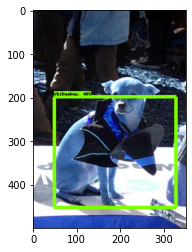

In [0]:
%matplotlib inline

import os
import cv2
import numpy as np
import tensorflow as tf
import sys
from matplotlib import pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


PATH_TO_CKPT = '/content/frozen_graph.pb'

PATH_TO_LABELS = '/content/label_map.pbtxt'

PATH_TO_IMAGE = '/content/dog_breed/data/images/n02085620_4290.jpg'

# Number of classes the object detector can identify
NUM_CLASSES = 5


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.40)
#image=cv2.resize(image,(500,500))
plt.imshow(image)